In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib import ticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import rcParams
from matplotlib import patches
import xarray as xr
import scipy.io
import astropy.constants as const
#rcParams['text.usetex'] = True
#rcParams['font.family'] = 'serif'
import pandas as pd
#import ChiantiPy.core as ch
import copy
from scipy import interpolate
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import importlib
import fitting_template
importlib.reload(fitting_template)
from fitting_template import FeXII_fit
from fitting_template import myGaussian1D
from astropy.modeling import models, fitting, Fittable1DModel, Parameter
from scipy.integrate import simps
import copy
from scipy.signal import find_peaks
plt.style.use('science')
rcParams['axes.linewidth'] = 1.2
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'cm'

In [4]:
m_p = const.m_p.cgs.value
k_b = const.k_B.cgs.value
c = const.c.cgs.value
rs = const.R_sun.cgs.value

In [5]:
#read dataset
awsom_data_set = scipy.io.readsav('../save/awsom_input_new.sav',verbose = True,python_dict=True)

--------------------------------------------------
Date: Sun Aug 23 03:35:19 2020
User: yjzhu
Host: Yingjies-MacBook-Pro.local
--------------------------------------------------
Format: 11
Architecture: x86_64
Operating System: darwin
IDL Version: 8.2
--------------------------------------------------
Successfully read 5 records of which:
 - 1 are of type TIMESTAMP
 - 2 are of type VARIABLE
 - 1 are of type VERSION
--------------------------------------------------
Available variables:
 - x [<class 'numpy.ndarray'>]
 - w [<class 'numpy.ndarray'>]
--------------------------------------------------


In [ ]:
awsom_data_set['w']

In [6]:
awsom_x = awsom_data_set['x'][0,0,0,:]
awsom_y = awsom_data_set['x'][1,0,:,0]
awsom_z = awsom_data_set['x'][2,:,0,0]
rho = awsom_data_set['w'][0,:,:,:]
n = rho/m_p
#n = np.nan_to_num(n,nan=0)
ux = awsom_data_set['w'][1,:,:,:]
uy = awsom_data_set['w'][2,:,:,:]
uz = awsom_data_set['w'][3,:,:,:]
bx = awsom_data_set['w'][4,:,:,:]
by = awsom_data_set['w'][5,:,:,:]
bz = awsom_data_set['w'][6,:,:,:]
I01 = awsom_data_set['w'][7,:,:,:]
I02 = awsom_data_set['w'][8,:,:,:]
p = awsom_data_set['w'][9,:,:,:]
t = p/n/k_b
#t = np.nan_to_num(t,nan=1e3)
p_e = awsom_data_set['w'][10,:,:,:]
t_e = p_e/n/k_b
t_e = np.nan_to_num(t_e,nan=1e3)
n = np.nan_to_num(n,nan=1)
n = n + 1
b_tot = np.sqrt(np.square(bx) + np.square(by) + np.square(bz))
u_tot = np.sqrt(np.square(ux) + np.square(uy) + np.square(uz))
bx_rot = np.zeros_like(bx)
by_rot = np.zeros_like(by)
bz_rot = np.zeros_like(bz)
ux_rot = np.zeros_like(ux)
uy_rot = np.zeros_like(uy)
uz_rot = np.zeros_like(uz)

rot_DD = np.array([[0.57707363367080688,0.80787801742553711,-0.11966264247894287],
                   [-0.81372493505477905,0.58125013113021851,0.0000000000000000],
                   [ 6.9553926587104797E-002,9.7372472286224365E-002,0.99281460046768188]])
for ii in range(ux.shape[0]):
    for jj in range(ux.shape[1]):
        for kk in range(ux.shape[2]):
            bx_rot[ii,jj,kk],by_rot[ii,jj,kk],bz_rot[ii,jj,kk] = np.matmul([bx[ii,jj,kk],by[ii,jj,kk],bz[ii,jj,kk]],rot_DD.T)
            ux_rot[ii,jj,kk],uy_rot[ii,jj,kk],uz_rot[ii,jj,kk] = np.matmul([ux[ii,jj,kk],uy[ii,jj,kk],uz[ii,jj,kk]],rot_DD.T)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [25]:
%store -r ctb_195
%store -r ctb_197
%store -r ctb_184
%store -r awsom_195_fwhm
%store -r awsom_195_fwhm_err
ctb_195.shape

(61, 601)

In [6]:
awsom_data_set['w'].shape

(14, 61, 2, 601)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: RuntimeWarning: divide by zero encountered in log10


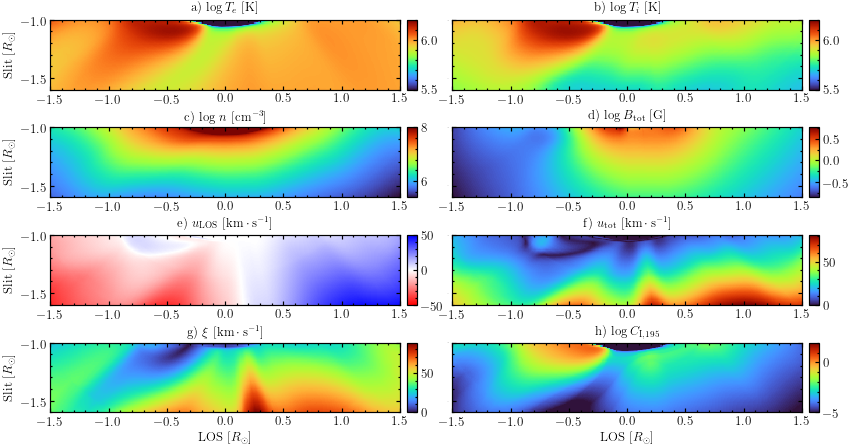

In [15]:
fig, axes = plt.subplots(4,2,figsize=(12,6.5))
im = axes[0,0].pcolormesh(awsom_x,awsom_z,np.log10(t_e[:,0,:]),rasterized=True,vmin=5.5,vmax=6.2,cmap="turbo")
axes[0,0].axis('scaled')
axes[0,0].set_ylabel(r'Slit $[R_\odot]$',fontsize=13)
axes[0,0].set_title(r'a) $\log T_e\ \mathrm{[K]}$',fontsize=13)
axes[0,0].tick_params(labelsize=13)
clb_ax00 = inset_axes(axes[0,0],width="3%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=axes[0,0].transAxes,
                 borderpad=0)
clb00 = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=axes[0,0],cax=clb_ax00)
clb_ax00.tick_params(labelsize=13)
clb_ax00.yaxis.set_minor_locator(AutoMinorLocator(5))
clb_ax00.yaxis.get_offset_text().set_fontsize(15)
#clb_ax00.set_ylabel(r'log $T_e$',fontsize=16)

im = axes[0,1].pcolormesh(awsom_x,awsom_z,np.log10(t[:,0,:]),rasterized=True,vmin=5.5,vmax=6.2,cmap="turbo")
axes[0,1].axis('scaled')
axes[0,1].set_title(r'b) $\log T_i\ \mathrm{[K]}$',fontsize=13)
axes[0,1].tick_params(labelsize=13)
axes[0,1].yaxis.set_major_locator(ticker.MultipleLocator(base=0.5))
axes[0,1].tick_params(axis="y",labelsize=0)

clb_ax01 = inset_axes(axes[0,1],width="3%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=axes[0,1].transAxes,
                 borderpad=0)
clb01 = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=axes[0,1],cax=clb_ax01)
clb_ax01.tick_params(labelsize=13)
clb_ax01.yaxis.set_minor_locator(AutoMinorLocator(5))
clb_ax01.yaxis.get_offset_text().set_fontsize(15)
#clb_ax01.set_ylabel(r'log $T_i$',fontsize=16)

im = axes[1,0].pcolormesh(awsom_x,awsom_z,np.log10(n[:,0,:]),vmax=8,rasterized=True,cmap="turbo")
axes[1,0].set_ylabel(r'Slit $[R_\odot]$',fontsize=13)
axes[1,0].axis('scaled')
axes[1,0].set_title(r'c) log $n\ \mathrm{[cm^{-3}]}$',fontsize=13)
axes[1,0].tick_params(labelsize=13)
clb_ax10 = inset_axes(axes[1,0],width="3%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=axes[1,0].transAxes,
                 borderpad=0)
clb10 = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=axes[1,0],cax=clb_ax10)
clb_ax10.tick_params(labelsize=13)
clb_ax10.yaxis.get_offset_text().set_fontsize(15)
clb_ax10.yaxis.set_minor_locator(AutoMinorLocator(5))
#clb_ax10.set_ylabel(r'log $n$',fontsize=16)

im = axes[1,1].pcolormesh(awsom_x,awsom_z,np.log10(b_tot[:,0,:]),rasterized=True,cmap="turbo")
axes[1,1].axis('scaled')
axes[1,1].set_title(r'd) $\log B_{\rm tot}\ \mathrm{[G]}$',fontsize=13)
axes[1,1].tick_params(labelsize=13)
axes[1,1].yaxis.set_major_locator(ticker.MultipleLocator(base=0.5))
axes[1,1].tick_params(axis="y",labelsize=0)

clb_ax11 = inset_axes(axes[1,1],width="3%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=axes[1,1].transAxes,
                 borderpad=0)
clb11 = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=axes[1,1],cax=clb_ax11)
clb_ax11.tick_params(labelsize=13)
clb_ax11.yaxis.get_offset_text().set_fontsize(15)
clb_ax11.yaxis.set_minor_locator(AutoMinorLocator(2))

im = axes[2,0].pcolormesh(awsom_x,awsom_z,ux_rot[:,0,:],vmin=-50,vmax=50,cmap="bwr_r",rasterized=True)
axes[2,0].set_ylabel(r'Slit $[R_\odot]$',fontsize=13)
axes[2,0].axis('scaled')
axes[2,0].set_title(r'e) $u_{\rm LOS}\ [\mathrm{km\cdot s^{-1}}]$',fontsize=13)
axes[2,0].tick_params(labelsize=13)
clb_ax20 = inset_axes(axes[2,0],width="3%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=axes[2,0].transAxes,
                 borderpad=0)
clb20 = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=axes[2,0],cax=clb_ax20)
clb_ax20.tick_params(labelsize=13)
clb_ax20.yaxis.get_offset_text().set_fontsize(15)
clb_ax20.yaxis.set_minor_locator(AutoMinorLocator(5))

im = axes[2,1].pcolormesh(awsom_x,awsom_z,u_tot[:,0,:],vmin=0,rasterized=True,cmap="turbo")
axes[2,1].axis('scaled')
axes[2,1].set_title(r'f) $u_{\rm tot}\ [\mathrm{km\cdot s^{-1}}]$',fontsize=13)
axes[2,1].tick_params(labelsize=13)
axes[2,1].yaxis.set_major_locator(ticker.MultipleLocator(base=0.5))
axes[2,1].tick_params(axis="y",labelsize=0)

clb_ax21 = inset_axes(axes[2,1],width="3%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=axes[2,1].transAxes,
                 borderpad=0)
clb21 = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=axes[2,1],cax=clb_ax21)
clb_ax21.tick_params(labelsize=13)
clb_ax21.yaxis.get_offset_text().set_fontsize(15)
clb_ax21.yaxis.set_minor_locator(AutoMinorLocator(5))

cos_theta = np.sqrt(1 - np.square(bx_rot)/np.square(b_tot))
vnt = 0.5*np.sqrt((I01 + I02)/m_p/n)*cos_theta
im = axes[3,0].pcolormesh(awsom_x,awsom_z,vnt[:,0,:]/1e5,vmin=0,rasterized=True,cmap="turbo")
axes[3,0].set_ylabel(r'Slit $[R_\odot]$',fontsize=13)
axes[3,0].set_xlabel(r'LOS $[R_\odot]$',fontsize=13)
axes[3,0].axis('scaled')
axes[3,0].set_title(r'g) $\xi\ [\mathrm{km\cdot s^{-1}}]$',fontsize=13)
axes[3,0].tick_params(labelsize=13)
clb_ax30 = inset_axes(axes[3,0],width="3%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=axes[3,0].transAxes,
                 borderpad=0)
clb30 = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=axes[3,0],cax=clb_ax30)
clb_ax30.tick_params(labelsize=13)
clb_ax30.yaxis.get_offset_text().set_fontsize(15)
clb_ax30.yaxis.set_minor_locator(AutoMinorLocator(5))
#clb_ax.set_ylabel(r'$\xi\ (\mathrm{km\cdot s^{-1}})$',fontsize=16)

%store -r ctb_195
im = axes[3,1].pcolormesh(awsom_x,awsom_z,np.log10(ctb_195),vmin=-5,vmax=2,rasterized=True,cmap="turbo")
axes[3,1].axis('scaled')
axes[3,1].set_title(r'h) $\log C_{\rm I,195}$',fontsize=13)
axes[3,1].set_xlabel(r'LOS $[R_\odot]$',fontsize=13)
axes[3,1].tick_params(labelsize=13)
axes[3,1].yaxis.set_major_locator(ticker.MultipleLocator(base=0.5))
axes[3,1].tick_params(axis="y",labelsize=0)

clb_ax31 = inset_axes(axes[3,1],width="3%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=axes[3,1].transAxes,
                 borderpad=0)
clb31 = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=axes[3,1],cax=clb_ax31)
clb_ax31.tick_params(labelsize=13)
clb_ax31.yaxis.get_offset_text().set_fontsize(15)
clb_ax31.yaxis.set_minor_locator(AutoMinorLocator(5))

for ax_ in axes.flatten():
    ax_.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax_.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax_.tick_params(which="major",width=1.2,length=4)
    ax_.tick_params(which="minor",width=1.2,length=2)
    
for ax_ in [clb_ax00,clb_ax01,clb_ax10,clb_ax11,clb_ax20,clb_ax21,clb_ax30,clb_ax31]:
    ax_.tick_params(which="major",width=1.2,length=4)
    ax_.tick_params(which="minor",width=1.2,length=2)

plt.subplots_adjust(bottom = 0.05,left=0.07,top=0.97,right=0.94,hspace=0,wspace=0.15)
plt.savefig(fname = '../figs/awsom_output.pdf', dpi = 300, format = 'pdf')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log10


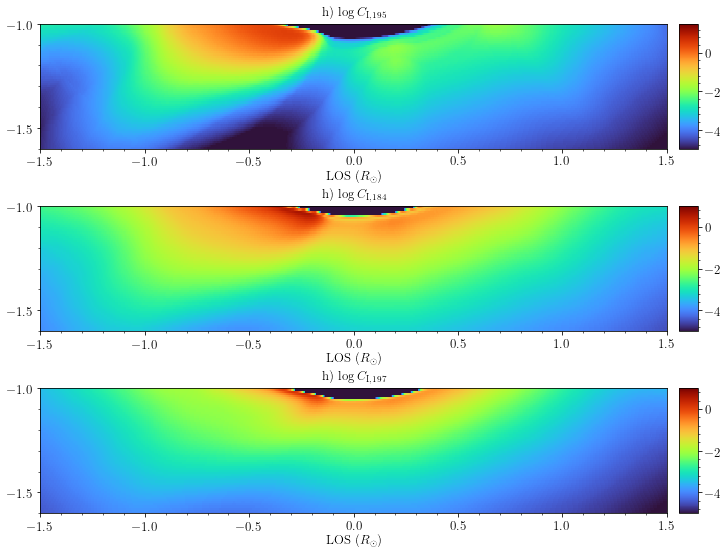

In [554]:
fig,axes = plt.subplots(3,1,figsize=(10,8))
im = axes[0].pcolormesh(awsom_x,awsom_z,np.log10(ctb_195),vmin=-5,vmax=1.5,rasterized=True,cmap="turbo")
axes[0].axis('scaled')
axes[0].set_title(r'h) $\log C_{\rm I,195}$',fontsize=13)
axes[0].set_xlabel(r'LOS $(R_\odot)$',fontsize=13)
axes[0].tick_params(labelsize=13)
axes[0].yaxis.set_major_locator(ticker.MultipleLocator(base=0.5))

clb_ax0 = inset_axes(axes[0],width="3%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=axes[0].transAxes,
                 borderpad=0)
clb0 = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=axes[0],cax=clb_ax0)
clb_ax0.tick_params(labelsize=13)
clb_ax0.yaxis.get_offset_text().set_fontsize(15)
clb_ax0.yaxis.set_minor_locator(AutoMinorLocator(5))


im = axes[1].pcolormesh(awsom_x,awsom_z,np.log10(ctb_184),vmin=-5,vmax=1,rasterized=True,cmap="turbo")
axes[1].axis('scaled')
axes[1].set_title(r'h) $\log C_{\rm I,184}$',fontsize=13)
axes[1].set_xlabel(r'LOS $(R_\odot)$',fontsize=13)
axes[1].tick_params(labelsize=13)
axes[1].yaxis.set_major_locator(ticker.MultipleLocator(base=0.5))

clb_ax1 = inset_axes(axes[1],width="3%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=axes[1].transAxes,
                 borderpad=0)
clb1 = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=axes[1],cax=clb_ax1)
clb_ax1.tick_params(labelsize=13)
clb_ax1.yaxis.get_offset_text().set_fontsize(15)
clb_ax1.yaxis.set_minor_locator(AutoMinorLocator(5))


im = axes[2].pcolormesh(awsom_x,awsom_z,np.log10(ctb_197),vmin=-5,vmax=1,rasterized=True,cmap="turbo")
axes[2].axis('scaled')
axes[2].set_title(r'h) $\log C_{\rm I,197}$',fontsize=13)
axes[2].set_xlabel(r'LOS $(R_\odot)$',fontsize=13)
axes[2].tick_params(labelsize=13)
axes[2].yaxis.set_major_locator(ticker.MultipleLocator(base=0.5))


clb_ax2 = inset_axes(axes[2],width="3%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=axes[2].transAxes,
                 borderpad=0)
clb2 = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=axes[2],cax=clb_ax2)
clb_ax2.tick_params(labelsize=13)
clb_ax2.yaxis.get_offset_text().set_fontsize(15)
clb_ax2.yaxis.set_minor_locator(AutoMinorLocator(5))

for ax_ in axes:
    ax_.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax_.yaxis.set_minor_locator(AutoMinorLocator(5))
    
plt.subplots_adjust(bottom = 0.05,left=0.07,top=0.97,right=0.94,hspace=0.1,wspace=0.15)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


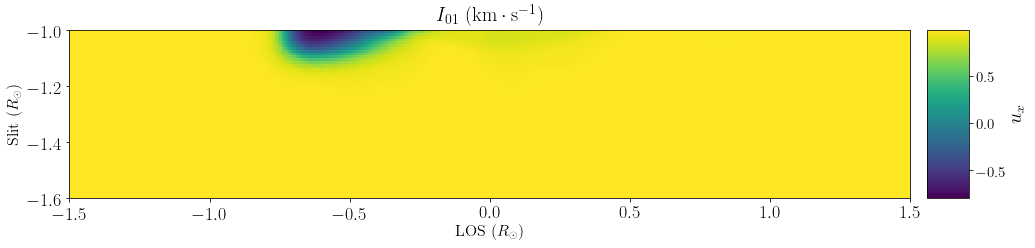

In [470]:
fig, ax = plt.subplots(figsize=(16,4.6))
im = ax.pcolormesh(awsom_x,awsom_z,(I01[:,0,:] - I02[:,0,:])/(I01[:,0,:] + I02[:,0,:]))
ax.axis('scaled')
ax.set_xlabel(r'LOS $(R_\odot)$',fontsize=16)
ax.set_ylabel(r'Slit $(R_\odot)$',fontsize=16)
ax.set_title(r'$I_{01}\ (\mathrm{km\cdot s^{-1}})$',fontsize=20)
ax.tick_params(labelsize=18)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
clb_ax = inset_axes(ax,width="5%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
clb_ax.tick_params(labelsize=15)
clb_ax.yaxis.get_offset_text().set_fontsize(16)
clb_ax.set_ylabel(r'$u_x$',fontsize=20)
plt.subplots_adjust(bottom = 0.02,left=0.13,top=0.99,right=0.86)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


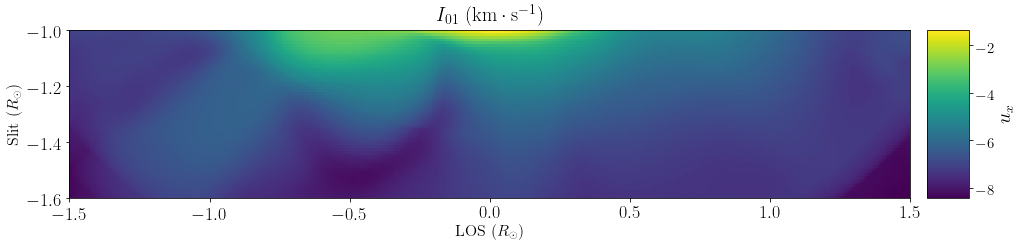

In [469]:
fig, ax = plt.subplots(figsize=(16,4.6))
im = ax.pcolormesh(awsom_x,awsom_z,np.log10(I02[:,0,:]))
ax.axis('scaled')
ax.set_xlabel(r'LOS $(R_\odot)$',fontsize=16)
ax.set_ylabel(r'Slit $(R_\odot)$',fontsize=16)
ax.set_title(r'$I_{01}\ (\mathrm{km\cdot s^{-1}})$',fontsize=20)
ax.tick_params(labelsize=18)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
clb_ax = inset_axes(ax,width="5%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
clb_ax.tick_params(labelsize=15)
clb_ax.yaxis.get_offset_text().set_fontsize(16)
clb_ax.set_ylabel(r'$u_x$',fontsize=20)
plt.subplots_adjust(bottom = 0.02,left=0.13,top=0.99,right=0.86)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: The following kwargs were not used by contour: 'linewidth'
  """


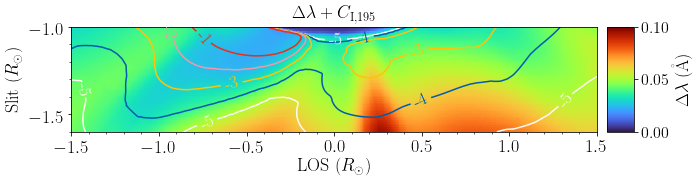

In [660]:
fig, ax = plt.subplots(figsize=(10,2.9))
width = np.sqrt(4*np.log(2)*np.square(195.1e-8/3e10)*(2*k_b*t[:,0,:]/56/m_p + np.square(vnt[:,0,:])) )*1e8
im = ax.pcolormesh(awsom_x,awsom_z,width,rasterized=True,vmin=0,vmax=0.1,cmap="turbo")
cs = ax.contour(awsom_x,awsom_z,np.log10(ctb_195/np.max(ctb_195)),levels=np.linspace(-5,-1,5),
                colors=["#FCFAF2","#005CAF",'#FFC408',"#F596AA",'#E83015'],linewidth=4)
ax.clabel(cs, inline=1, fontsize=18,fmt=r"%1.0f")
ax.axis('scaled')
ax.set_xlabel(r'LOS $(R_\odot)$',fontsize=18)
ax.set_ylabel(r'Slit $(R_\odot)$',fontsize=18)
ax.set_title("$\Delta \lambda + C_{\mathrm{I,195}}$",fontsize=18)
ax.tick_params(labelsize=18)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
clb_ax = inset_axes(ax,width="5%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
clb_ax.tick_params(labelsize=16)
clb_ax.set_ylabel(r'$\Delta \lambda\ \mathrm{(\AA)}$',fontsize=18)
clb_ax.yaxis.get_offset_text().set_fontsize(16)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.subplots_adjust(bottom = 0.05,left=0.12,top=0.99,right=0.85)
plt.savefig(fname = '../figs/ctb_width.pdf', dpi = 300, format = 'pdf')

In [54]:
n.shape

(61, 21, 601)

In [259]:
my_ctb_195 = np.zeros_like(ctb_195)
for ii in range(61):
    for jj in range(601):
        my_ctb_195[ii,jj] = line_xr.interp(logT=np.log10(t_e[ii,0,jj]),logN=np.log10(n[ii,0,jj]/0.83))['logG'].values[()]

In [266]:
my_ctb_195_cor = np.nan_to_num(my_ctb_195,nan=-100)
my_ctb_195_final = np.power(10,my_ctb_195_cor + 2*np.log10(n[:,0,:]/0.83))*rs/600

In [273]:
ctb_195.shape

(61, 601)

In [472]:
ctb195_ratio = np.zeros(61)
for ii in range(61):
    streamer_index_ = np.where(ctb_195[ii,:300] > 1e-4)
    streamer_ctb_ = np.sum(ctb_195[ii][streamer_index_])
    streamer_ratio_ = streamer_ctb_/np.sum(ctb_195[ii,:])
    ctb195_ratio[ii] = streamer_ratio_

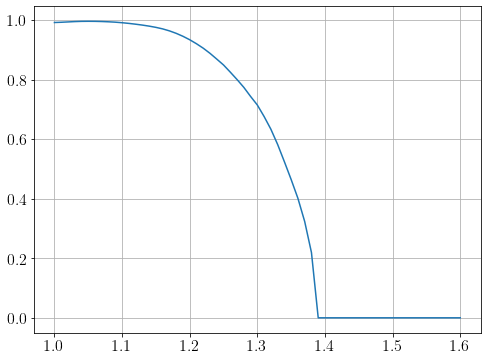

In [510]:
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(-awsom_z, ctb195_ratio)
ax.grid("on")
ax.tick_params(labelsize=16)

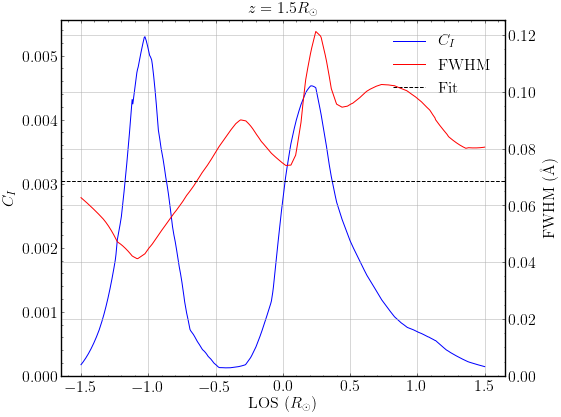

In [26]:
fig,ax = plt.subplots(figsize=(8,6))
ii = 10
ln1, = ax.plot(awsom_x, ctb_195[ii,:]/np.sum(ctb_195[ii,:]),color="blue",label=r"$C_I$")
ax2 = ax.twinx()
ln2, = ax2.plot(awsom_x,2.355*width_awsom[ii,:],color="r",label=r"FWHM")
ln3 = ax2.axhline(awsom_195_fwhm[ii],color="black",label=r"Fit",ls="--")
ax.set_title(r"$z = {:.2g} R_\odot$".format(-awsom_z[ii]),fontsize=16)
ax.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax.set_xlabel("LOS ($R_\odot$)",fontsize=16)
ax.set_ylabel(r"$C_I$",fontsize=16)
ax2.set_ylabel(r"FWHM (\mbox{\AA})",fontsize=16)
ax2.grid("on")
ax.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)
ax.grid("on",axis="x")
leg = [ln1,ln2,ln3]
ax.legend(leg,[leg_.get_label() for leg_ in leg],loc = 'best',fontsize = 16,frameon=False)
plt.tight_layout()
plt.savefig(fname = '../figs/ctb_fwhm_cut.png', dpi = 300, format = 'png')

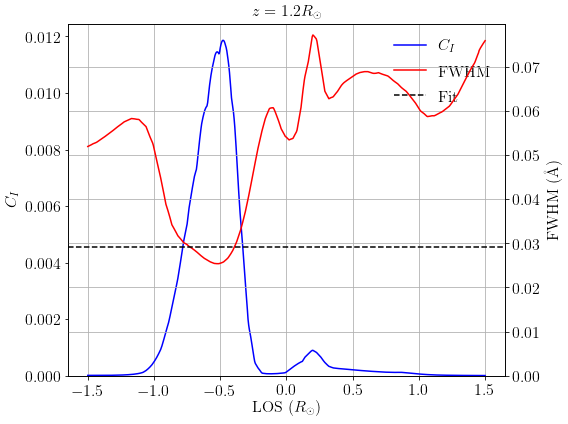

In [526]:
fig,ax = plt.subplots(figsize=(8,6))
ii = 40
ln1, = ax.plot(awsom_x, ctb_195[ii,:]/np.sum(ctb_195[ii,:]),color="blue",label=r"$C_I$")
ax2 = ax.twinx()
ln2, = ax2.plot(awsom_x,2.355*width_awsom[ii,:],color="r",label=r"FWHM")
ln3 = ax2.axhline(awsom_195_fwhm[ii],color="black",label=r"Fit",ls="--")
ax.set_title(r"$z = {:.2g} R_\odot$".format(-awsom_z[ii]),fontsize=16)
ax.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax.set_xlabel("LOS ($R_\odot$)",fontsize=16)
ax.set_ylabel(r"$C_I$",fontsize=16)
ax2.set_ylabel(r"FWHM (\mbox{\AA})",fontsize=16)
ax2.grid("on")
ax.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)
ax.grid("on",axis="x")
leg = [ln1,ln2,ln3]
ax.legend(leg,[leg_.get_label() for leg_ in leg],loc = 'best',fontsize = 16,frameon=False)
plt.tight_layout()
plt.savefig(fname = '../figs/ctb_fwhm_cut_12.png', dpi = 300, format = 'png')

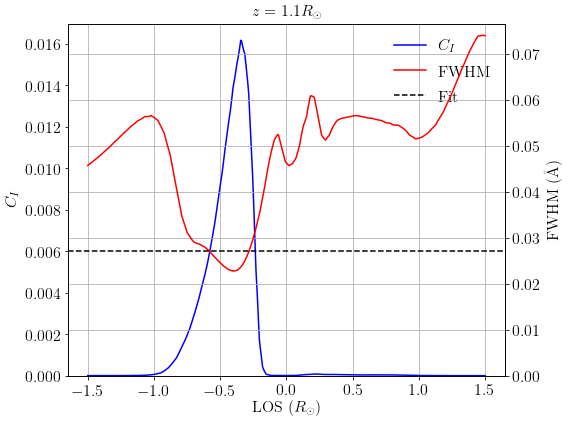

In [556]:
fig,ax = plt.subplots(figsize=(8,6))
ii = 50
ln1, = ax.plot(awsom_x, ctb_195[ii,:]/np.sum(ctb_195[ii,:]),color="blue",label=r"$C_I$")
ax2 = ax.twinx()
ln2, = ax2.plot(awsom_x,2.355*width_awsom[ii,:],color="r",label=r"FWHM")
ln3 = ax2.axhline(awsom_195_fwhm[ii],color="black",label=r"Fit",ls="--")
ax.set_title(r"$z = {:.2g} R_\odot$".format(-awsom_z[ii]),fontsize=16)
ax.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax.set_xlabel("LOS ($R_\odot$)",fontsize=16)
ax.set_ylabel(r"$C_I$",fontsize=16)
ax2.set_ylabel(r"FWHM (\mbox{\AA})",fontsize=16)
ax2.grid("on")
ax.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)
ax.grid("on",axis="x")
leg = [ln1,ln2,ln3]
ax.legend(leg,[leg_.get_label() for leg_ in leg],loc = 'best',fontsize = 16,frameon=False)
plt.tight_layout()
#plt.savefig(fname = '../figs/ctb_fwhm_cut_12.png', dpi = 300, format = 'png')

1.7578091441070027


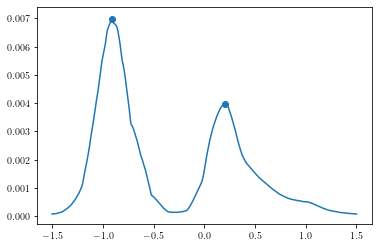

In [648]:
ii = 20
peaks, props = find_peaks(ctb_195[ii,:]/np.sum(ctb_195[ii,:]), height=0.0002,distance = 100,width=20)

plt.plot(awsom_x, ctb_195[ii,:]/np.sum(ctb_195[ii,:]))
plt.scatter(awsom_x[peaks], ctb_195[ii,peaks]/np.sum(ctb_195[ii,:]))
print(props['peak_heights'][0]/props['peak_heights'][1])

In [609]:
aa = [1,2,3,4,5]
np.argmin(aa[2:4])

0

In [16]:
def ch_st_ctb(x,ctb,peak_height):
    peaks, props = find_peaks(ctb, height=peak_height,distance = 100,width=20)
    if len(peaks) <= 1:
        return 0,1
    else:
        if props['peak_heights'][0]/props['peak_heights'][1] > 60:
            return 0,1
        else:
            mid = np.argmin(ctb[peaks[0]:peaks[1]]) + peaks[0]
            ch_ctb = np.sum(ctb[mid:])
            st_ctb = np.sum(ctb[:mid])
            return ch_ctb, st_ctb

def ch_st_ctbs(x,ctbs,peak_height = 0.0001):
    ch_ctbs = np.zeros(ctbs.shape[0])
    st_ctbs = np.zeros(ctbs.shape[0])
    for ii in range(ctbs.shape[0]):
        ch_ctbs[ii], st_ctbs[ii] = ch_st_ctb(x,ctbs[ii,:]/np.sum(ctbs[ii,:]),peak_height=peak_height)
    return ch_ctbs, st_ctbs

In [17]:
ch_ctbs_195, st_ctbs_195 = ch_st_ctbs(awsom_x, ctb_195)

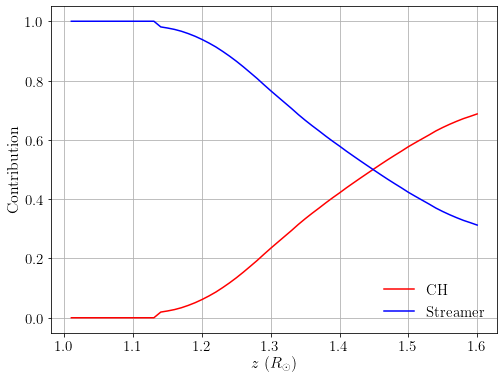

In [653]:
fig, ax = plt.subplots(figsize=(8,6))
ln1, = ax.plot(-awsom_z[:-1],ch_ctbs_195[:-1],color="red",label="CH")
ln2, = ax.plot(-awsom_z[:-1],st_ctbs_195[:-1],color="blue",label="Streamer")
ax.tick_params(labelsize=15)
leg = [ln1,ln2]
ax.grid("on")
ax.set_xlabel(r"$z\ (R_\odot)$",fontsize=16)
ax.set_ylabel(r"Contribution",fontsize=16)
ax.legend(leg,[leg_.get_label() for leg_ in leg],loc = 'lower right',fontsize = 15,frameon=False)
plt.savefig(fname = '../figs/ctb_chst.png', dpi = 300, format = 'png')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10


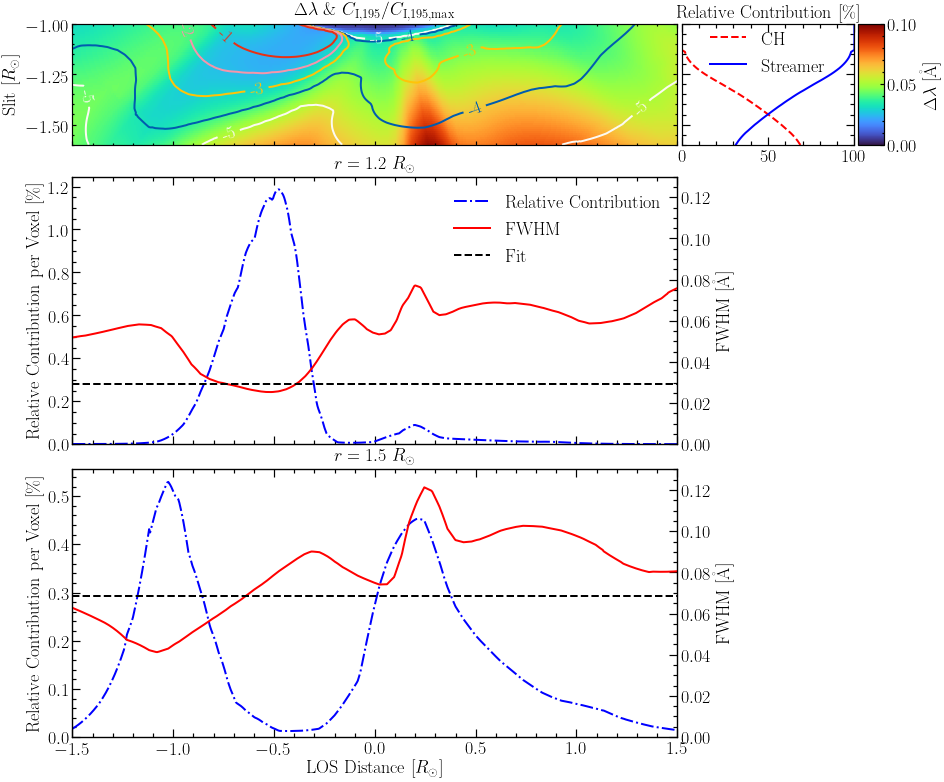

In [63]:
left, width = 0.1, 0.7
top, height1 = 0.9, width*0.8/3
spacing = 0.035
height2 = (1 - height1 - 2*spacing)/2 

rect_dist = [left, top-height1, width, height1]
rect_distx1 = [left, top - height1 - height2 - spacing, width, height2]
rect_distx2 = [left, top - height1 - 2*height2 - 2*spacing, width, height2]
rect_disty = [left + width + spacing-0.03, top-height1+0.009, 0.2, height1-0.018]

fig = plt.figure(figsize=(12, 10))
ax_dist = plt.axes(rect_dist)
ax_dist.tick_params(direction='in', top=True, right=True,labelbottom=False)
ax_distx1 = plt.axes(rect_distx1)
ax_distx1.tick_params(direction='in', labelbottom=False)
ax_distx2 = plt.axes(rect_distx2)
ax_distx2.tick_params(direction='in')
#ax_distx.set_xlim(energies[0],energies[-1])
ax_disty = plt.axes(rect_disty)
ax_disty.tick_params(direction='in', labelleft=False)
#ax_disty.set_ylim(angles[0],angles[-1])

width = np.sqrt(4*np.log(2)*np.square(195.1e-8/3e10)*(2*k_b*t[:,0,:]/56/m_p + np.square(vnt[:,0,:])) )*1e8
im = ax_dist.pcolormesh(awsom_x,awsom_z,width,rasterized=True,vmin=0,vmax=0.1,cmap="turbo")
cs = ax_dist.contour(awsom_x,awsom_z,np.log10(ctb_195/np.max(ctb_195)),levels=np.linspace(-5,-1,5),
                colors=["#FCFAF2","#005CAF",'#FFC408',"#F596AA",'#E83015'],linewidths=2)
ax_dist.clabel(cs, inline=1, fontsize=18,fmt=r"%1.0f")
ax_dist.axis('scaled')
#ax_dist.set_xlabel(r'LOS $(R_\odot)$',fontsize=18)
ax_dist.set_ylabel(r'Slit $[R_\odot]$',fontsize=18)
ax_dist.set_title("$\Delta \lambda\ \&\ C_{\mathrm{I,195}}/C_{\mathrm{I,195,max}}$",fontsize=18)
ax_dist.tick_params(labelsize=18)
ax_dist.tick_params(which="major",width=1.2,length=4)
ax_dist.tick_params(which="minor",width=1.2,length=2)

clb_ax = inset_axes(ax_disty,width="15%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0, 1, 1),
                 bbox_transform=ax_disty.transAxes,
                 borderpad=0)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax_disty,cax=clb_ax)
clb_ax.tick_params(labelsize=18)
clb_ax.tick_params(which="major",width=1.2,length=4)
clb_ax.tick_params(which="minor",width=1.2,length=2)
clb_ax.set_ylabel(r'$\Delta \lambda\ \mathrm{[\AA]}$',fontsize=18)
clb_ax.yaxis.get_offset_text().set_fontsize(18)

ax_dist.get_shared_y_axes().join(ax_dist, ax_disty)
ln1, = ax_disty.plot(ch_ctbs_195[:-1]*100,awsom_z[:-1],color="red",label="CH",lw=2,ls="--")
ln2, = ax_disty.plot(st_ctbs_195[:-1]*100,awsom_z[:-1],color="blue",label="Streamer",lw=2)
ax_disty.set_title("Relative Contribution [\%]",fontsize=18)
ax_disty.set_ylim(-1.6,-1)
ax_disty.set_xlim(0,100)
ax_disty.tick_params(labelsize=18)
leg = [ln1,ln2]
ax_disty.legend(leg,[leg_.get_label() for leg_ in leg],bbox_to_anchor=(0.5,0.45),fontsize = 18,frameon=False)

ii = 40
ln1, = ax_distx1.plot(awsom_x, ctb_195[ii,:]/np.sum(ctb_195[ii,:])*100,color="blue",label=r"Relative Contribution",lw=2,ls="-.")
ax_distx1p = ax_distx1.twinx()
ln2, = ax_distx1p.plot(awsom_x,2.355*width_awsom[ii,:],color="r",label=r"FWHM",lw=2)
ln3 = ax_distx1p.axhline(awsom_195_fwhm[ii],color="black",label=r"Fit",ls="--",lw=2)
ax_distx1.set_title(r"$r = {:.2g}\ R_\odot$".format(-awsom_z[ii]),fontsize=18)
ax_distx1.tick_params(labelsize=18)
ax_distx1p.tick_params(labelsize=18)
ax_distx1.set_ylabel(r"Relative Contribution per Voxel [\%]",fontsize=18)
ax_distx1p.set_ylabel(r"FWHM [\mbox{\AA}]",fontsize=18)
ax_distx1.set_ylim(bottom=0)
ax_distx1p.set_ylim(bottom=0,top=0.13)
ax_distx1.set_xlim(-1.5,1.5)
leg = [ln1,ln2,ln3]
ax_distx1.legend(leg,[leg_.get_label() for leg_ in leg],loc = 'upper right',fontsize = 18,frameon=False)


ii = 10
ln1, = ax_distx2.plot(awsom_x, ctb_195[ii,:]/np.sum(ctb_195[ii,:])*100,color="blue",label=r"$C_I$",lw=2,ls="-.")
ax_distx2p = ax_distx2.twinx()
ln2, = ax_distx2p.plot(awsom_x,2.355*width_awsom[ii,:],color="r",label=r"FWHM",lw=2)
ln3 = ax_distx2p.axhline(awsom_195_fwhm[ii],color="black",label=r"Fit",ls="--",lw=2)
ax_distx2.set_title(r"$r = {:.2g}\ R_\odot$".format(-awsom_z[ii]),fontsize=18)
ax_distx2.tick_params(labelsize=18)
ax_distx2p.tick_params(labelsize=18)
ax_distx2.set_xlabel("LOS Distance [$R_\odot$]",fontsize=18)
ax_distx2.set_ylabel(r"Relative Contribution per Voxel [\%]",fontsize=18)
ax_distx2p.set_ylabel(r"FWHM [\mbox{\AA}]",fontsize=18)
ax_distx2.set_ylim(bottom=0)
ax_distx2.set_xlim(-1.5,1.5)
ax_distx2p.set_ylim(bottom=0,top=0.13)
#ax.grid("on",axis="x")
#leg = [ln1,ln2,ln3]
#ax_distx2.legend(leg,[leg_.get_label() for leg_ in leg],bbox_to_anchor=(0.8,0.2),fontsize = 16,frameon=False)
for ax_ in [ax_distx1,ax_distx1p,ax_distx2,ax_distx2p,ax_disty]:
    ax_.tick_params(which="major",width=1.2,length=8)
    ax_.tick_params(which="minor",width=1.2,length=4)

plt.savefig(fname = '../figs/ctb_width_v2.pdf', dpi = 300, format = 'pdf')


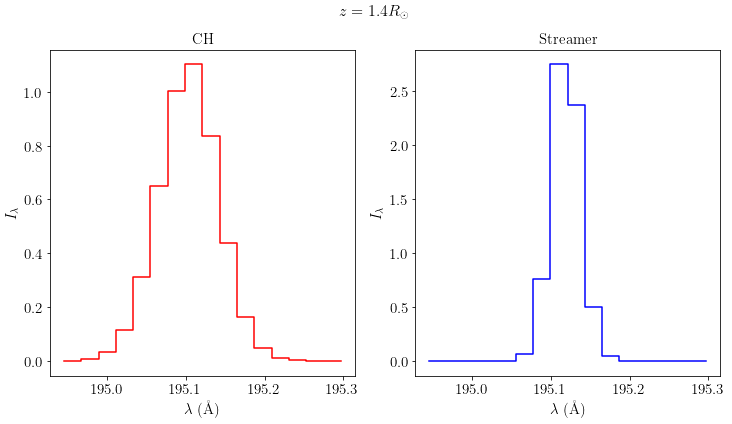

In [650]:
ii = 20
peaks, props = find_peaks(ctb_195[ii,:]/np.sum(ctb_195[ii,:]), height=0.0002,distance = 100,width=20)
mid = np.argmin(ctb_195[ii,peaks[0]:peaks[1]]) + peaks[0]

my_195_ch = np.sum(ctb_195_zxl[:,mid:,:],axis=1)
my_195_st = np.sum(ctb_195_zxl[:,:mid,:],axis=1)

fig, axes = plt.subplots(1,2,figsize=(12,6))
axes[0].step(awsom_wvl_195,my_195_ch[ii,:],color="red")

axes[1].step(awsom_wvl_195,my_195_st[ii,:],color="blue")
axes[0].set_title(r"CH",fontsize=15)
axes[1].set_title(r"Streamer",fontsize=15)
fig.suptitle(r"$z = {:.2g} R_\odot$".format(-awsom_z[ii]),fontsize=16)

for ax_ in axes:
    ax_.tick_params(labelsize=15)
    ax_.set_xlabel(r"$\lambda\ (\mathrm{\AA})$",fontsize=15)
    ax_.set_ylabel(r"$I_\lambda $",fontsize=15)

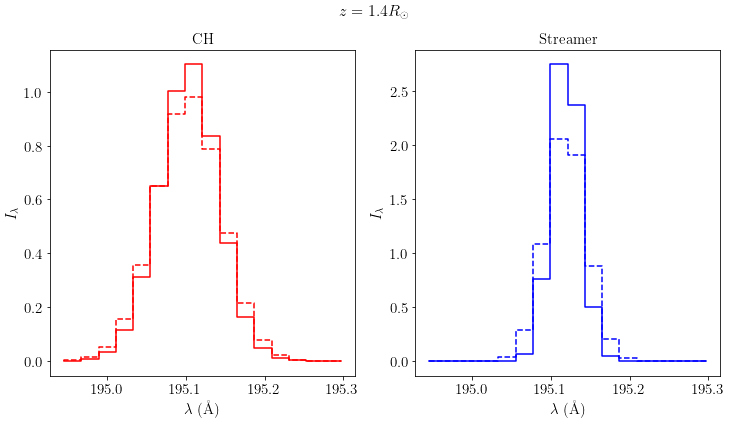

In [651]:
ii = 20
peaks, props = find_peaks(ctb_195[ii,:]/np.sum(ctb_195[ii,:]), height=0.0002,distance = 100,width=20)
mid = np.argmin(ctb_195[ii,peaks[0]:peaks[1]]) + peaks[0]

my_195_ch_br = np.sum(ctb_195_br[:,mid:,:],axis=1)
my_195_st_br = np.sum(ctb_195_br[:,:mid,:],axis=1)

fig, axes = plt.subplots(1,2,figsize=(12,6))
axes[0].step(awsom_wvl_195,my_195_ch[ii,:],color="red")
axes[0].step(awsom_wvl_195,my_195_ch_br[ii,:],color="red",ls="--")

axes[1].step(awsom_wvl_195,my_195_st[ii,:],color="blue")
axes[1].step(awsom_wvl_195,my_195_st_br[ii,:],color="blue",ls="--")
axes[0].set_title(r"CH",fontsize=15)
axes[1].set_title(r"Streamer",fontsize=15)
fig.suptitle(r"$z = {:.2g} R_\odot$".format(-awsom_z[ii]),fontsize=16)

for ax_ in axes:
    ax_.tick_params(labelsize=15)
    ax_.set_xlabel(r"$\lambda\ (\mathrm{\AA})$",fontsize=15)
    ax_.set_ylabel(r"$I_\lambda $",fontsize=15)

In [631]:
ctb_195_zxl.shape

(61, 601, 17)

In [19]:
def ch_st_ctb(x,ctb,peak_height):
    peaks, props = find_peaks(ctb, height=peak_height,distance = 100,width=20)
    if len(peaks) <= 1:
        return 0,1
    else:
        if props['peak_heights'][0]/props['peak_heights'][1] > 60:
            return 0,1
        else:
            mid = np.argmin(ctb[peaks[0]:peaks[1]]) + peaks[0]
            ch_ctb = np.sum(ctb[mid:])
            st_ctb = np.sum(ctb[:mid])
            return ch_ctb, st_ctb
        
def ch_st_ctbs(x,ctbs,peak_height = 0.0001):
    ch_ctbs = np.zeros(ctbs.shape[0])
    st_ctbs = np.zeros(ctbs.shape[0])
    for ii in range(ctbs.shape[0]):
        ch_ctbs[ii], st_ctbs[ii] = ch_st_ctb(x,ctbs[ii,:]/np.sum(ctbs[ii,:]),peak_height=peak_height)
    return ch_ctbs, st_ctbs

In [20]:
def better_st_identify(x,ctb,width,peak_height,threshold=0.001):
    col = []
    peaks, props = find_peaks(ctb/np.sum(ctb), height=peak_height,distance = 100,width=20)
    if len(peaks) <= 1:
        max_value = np.max(ctb)
        col1 = np.where(ctb>1e-2*max_value)[0].tolist()
        col2 = np.where(width<0.037)[0].tolist()
        col = list(set(col1).intersection(col2))
    else:
        if props['peak_heights'][0]/props['peak_heights'][1] > 60:
            max_value = np.max(ctb)
            col1 = np.where(ctb>1e-2*max_value)[0].tolist()
            col2 = np.where(width<0.037)[0].tolist()
            col = list(set(col1).intersection(col2))
        else:
            mid = np.argmin(ctb[peaks[0]:peaks[1]]) + peaks[0]
            max_value = np.max(ctb[:mid])
            col1 = np.where(ctb[:mid]>threshold*max_value)[0].tolist()
            col2 = np.where(width<0.037)[0].tolist()
            col = list(set(col1).intersection(col2))
    return col
    
def better_st_identify_all(x,ctbs,widths,peak_height=0.0001):
    rows = []
    cols = []
    for ii in range(ctbs.shape[0]):
        col = better_st_identify(x,ctbs[ii,:],widths[ii,],peak_height=peak_height)
        rows = rows + [ii]*len(col)
        cols = cols + col
    return (np.array(rows),np.array(cols))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]
/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:2707: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


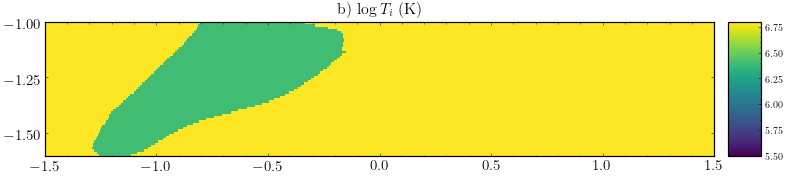

In [21]:
my_t_ch = copy.deepcopy(t[:,0,:])
my_t_stch = copy.deepcopy(t[:,0,:])
my_t_br = np.ones_like(t[:,0,:])*np.power(10,6.8)
my_t_better = np.ones_like(t[:,0,:])*np.power(10,6.8)

st_index_better = better_st_identify_all(awsom_x, ctb_195,width)
#st_index_better = np.where(width[:,:300]<0.035)
my_t_better[st_index_better] = np.power(10,6.4)

streamer_index = np.where(ctb_195[:,:300] > 2e-3)
ch_index = np.where(ctb_195[:,280:] > 1e-4)
my_t_stch[streamer_index] = np.power(10,6.4)
my_t_br[streamer_index] = np.power(10,6.4)
my_t_stch[:,280:][ch_index] = np.power(10,6.8)
my_t_ch[:,280:][ch_index] = np.power(10,6.8)


fig, ax = plt.subplots(figsize=(12,8))
im = ax.pcolormesh(awsom_x,awsom_z,np.log10(my_t_better),rasterized=True,vmin=5.5)
ax.axis('scaled')
ax.set_title(r'b) $\log T_i\ \mathrm{(K)}$',fontsize=16)
ax.tick_params(labelsize=15)
ax.set_yticks([-1.0,-1.25,-1.5])
clb_ax = inset_axes(ax,width="5%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
clb01 = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
clb_ax01.tick_params(labelsize=15)
clb_ax01.yaxis.get_offset_text().set_fontsize(15)

In [22]:
streamer_index

(array([22, 22, 22, ..., 60, 60, 60]),
 array([109, 110, 111, ..., 227, 228, 229]))

In [23]:
%store -r awsom_wvl_195

ctb_195_zxl = np.zeros((61,601,awsom_wvl_195.shape[0]))
line_cent_195 = 195.1190 - ux_rot[:,0,:]*1e5/c*195.1190
cos_theta = np.sqrt(1 - np.square(bx_rot)/np.square(b_tot))

vnt = 0.5*np.sqrt((I01 + I02)/m_p/n)*cos_theta
#width = np.sqrt(4*np.log(2)*np.square(195.119e-8/c)*(2*k_b*t[:,10,:]/56/m_p + np.square(vnt[:,10,:])) )*1e8
width_awsom = np.sqrt(np.square(195.119e-8/c)*(k_b*t[:,0,:]/56/m_p + np.square(vnt[:,0,:])) )*1e8
width_ch = np.sqrt(np.square(195.119e-8/c)*(k_b*my_t_ch/56/m_p + np.square(vnt[:,0,:])) )*1e8
width_stch = np.sqrt(np.square(195.119e-8/c)*(k_b*my_t_stch/56/m_p + np.square(vnt[:,0,:])) )*1e8
width_br = np.sqrt(np.square(195.119e-8/c)*(k_b*my_t_better/56/m_p + np.square(vnt[:,0,:])) )*1e8

#phi_zxl = 1/(width[:,:,np.newaxis]*np.sqrt(2*np.pi)/2.355)* \
#    np.exp(-np.square(awsom_wvl_195[np.newaxis,np.newaxis,:] - line_cent_195[:,:,np.newaxis])/(2*np.square(width[:,:,np.newaxis]/2.355)))

phi_zxl = 1/(width_awsom[:,:,np.newaxis]*np.sqrt(2*np.pi))* \
    np.exp(-np.square(awsom_wvl_195[np.newaxis,np.newaxis,:] - line_cent_195[:,:,np.newaxis])/(2*np.square(width_awsom[:,:,np.newaxis])))

phi_ch = 1/(width_ch[:,:,np.newaxis]*np.sqrt(2*np.pi))* \
    np.exp(-np.square(awsom_wvl_195[np.newaxis,np.newaxis,:] - line_cent_195[:,:,np.newaxis])/(2*np.square(width_ch[:,:,np.newaxis])))

phi_stch = 1/(width_stch[:,:,np.newaxis]*np.sqrt(2*np.pi))* \
    np.exp(-np.square(awsom_wvl_195[np.newaxis,np.newaxis,:] - line_cent_195[:,:,np.newaxis])/(2*np.square(width_stch[:,:,np.newaxis])))

phi_br = 1/(width_br[:,:,np.newaxis]*np.sqrt(2*np.pi))* \
    np.exp(-np.square(awsom_wvl_195[np.newaxis,np.newaxis,:] - line_cent_195[:,:,np.newaxis])/(2*np.square(width_br[:,:,np.newaxis])))

ctb_195_zxl = ctb_195[:,:,np.newaxis]*phi_zxl
ctb_195_ch = ctb_195[:,:,np.newaxis]*phi_ch
ctb_195_stch = ctb_195[:,:,np.newaxis]*phi_stch
ctb_195_br = ctb_195[:,:,np.newaxis]*phi_br
#ctb_195_zxl = my_ctb_195_final[:,:,np.newaxis]*phi_zxl

my_195_profile = np.sum(ctb_195_zxl,axis=1)
my_195_profile_ch = np.sum(ctb_195_ch,axis=1)
my_195_profile_stch = np.sum(ctb_195_stch,axis=1)
my_195_profile_br = np.sum(ctb_195_br,axis=1)

FeXII_195_awsom = FeXII_fit(my_195_profile,awsom_wvl_195,[1,195.05,0.04,0.5],err = np.ones((61,17))*1e-5)
FeXII_195_awsom.run_lse()
fwhm_195_awsom = FeXII_195_awsom.get_para()[:,2]
fwhm_195_awsom_err = FeXII_195_awsom.get_error()[:,2]

FeXII_195_ch = FeXII_fit(my_195_profile_ch,awsom_wvl_195,[1,195.05,0.04,0.5],err = np.ones((61,17))*1e-5)
FeXII_195_ch.run_lse()
fwhm_195_ch = FeXII_195_ch.get_para()[:,2]
fwhm_195_ch_err = FeXII_195_ch.get_error()[:,2]

FeXII_195_stch = FeXII_fit(my_195_profile_stch,awsom_wvl_195,[1,195.05,0.04,0.5],err = np.ones((61,17))*1e-5)
FeXII_195_stch.run_lse()
fwhm_195_stch = FeXII_195_stch.get_para()[:,2]
fwhm_195_stch_err = FeXII_195_stch.get_error()[:,2]

FeXII_195_br = FeXII_fit(my_195_profile_br,awsom_wvl_195,[1,195.05,0.04,0.5],err = np.ones((61,17))*1e-5)
FeXII_195_br.run_lse()
fwhm_195_br = FeXII_195_br.get_para()[:,2]
fwhm_195_br_err = FeXII_195_br.get_error()[:,2]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


60 fit again
60 fit again
60 fit again
60 fit again


In [29]:
%store -r r_coord
%store -r fwhm_195_cor_mcmc
%store -r fwhm_195_err_down_mcmc
%store -r fwhm_195_err_up_mcmc

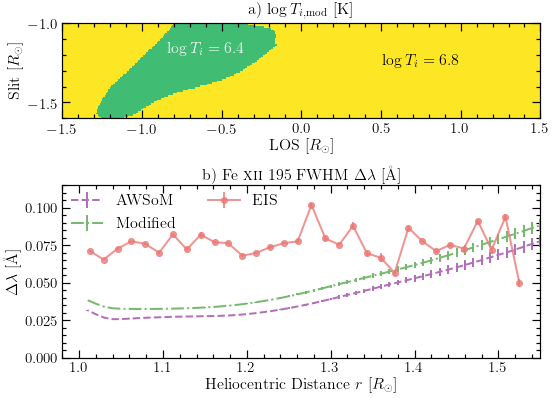

In [51]:
fig,ax = plt.subplots(figsize=(8,5.5))

ax1 = plt.subplot2grid((6,1),(0,0),rowspan = 2,colspan = 1)
ax2 = plt.subplot2grid((6,1),(3,0),rowspan = 3,colspan = 1)

im = ax1.pcolormesh(awsom_x,awsom_z,np.log10(my_t_better),rasterized=True,vmin=5.5)
ax1.axis('scaled')
ax1.set_ylabel(r'Slit $[R_\odot]$',fontsize=16)
ax1.set_xlabel(r'LOS $[R_\odot]$',fontsize=16)
ax1.set_title(r'a) $\log T_{i,\mathrm{mod}}\ \mathrm{[K]}$',fontsize=16)
ax1.tick_params(labelsize=15)
ax1.yaxis.set_major_locator(ticker.MultipleLocator(base=0.5))
ax1.text(-0.6,-1.18,r'$\log T_i = 6.4$',ha = 'center',va = 'center', color = 'w',fontsize = 16,linespacing=1.5)
ax1.text(0.75,-1.25,r'$\log T_i = 6.8$',ha = 'center',va = 'center', color = 'black',fontsize = 16,linespacing=1.5)
#clb_ax = inset_axes(ax1,width="5%",height= "100%",loc='lower left',
#                bbox_to_anchor=(1.02, 0., 1, 1),
#                 bbox_transform=ax1.transAxes,
#                 borderpad=0)
#clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax1,cax=clb_ax)
#clb_ax.tick_params(labelsize=15)
#clb_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
#clb_ax.yaxis.get_offset_text().set_fontsize(15)

ln1 = ax2.errorbar(-awsom_z[:-1],awsom_195_fwhm[:-1],awsom_195_fwhm_err[:-1],label="AWSoM",color='#b26fba',lw=2,ls="--")
#ax.errorbar(-awsom_z[:-1],fwhm_195_ch[:-1],fwhm_195_ch_err[:-1],label="AWSoM-a",color='#5DAC81')
#ax.errorbar(-awsom_z[:-1],fwhm_195_stch[:-1],fwhm_195_stch_err[:-1],label="AWSoM-b",color='#B28FCE')
ln2 = ax2.errorbar(-awsom_z[:-1],fwhm_195_br[:-1],fwhm_195_br_err[:-1],label="Modified",color="#77ba6f",lw=2,ls="-.")
ln3 = ax2.errorbar(r_coord,fwhm_195_cor_mcmc,yerr = [fwhm_195_err_down_mcmc,fwhm_195_err_up_mcmc],
                   color = "#EB7A77",linewidth=2,alpha=0.8,label="EIS",marker="o")
ax2.set_ylabel(r'$\Delta \lambda\ \mathrm{[\AA]}$',fontsize=16)
ax2.tick_params(labelsize=15)
ax2.set_ylim(0,0.115)
ax2.set_xlabel(r'Heliocentric Distance $r\ [R_\odot]$',fontsize=16)
ax2.set_title(r'b) Fe \textsc{xii} 195 FWHM $\Delta \lambda\ \mathrm{[\AA]}$',fontsize=16)
ax2.set_xlim(0.98,1.55)

leg = [ln1,ln2,ln3]
ax2.legend(leg,[leg_.get_label() for leg_ in leg],bbox_to_anchor=(0.48,0.65),fontsize = 16,frameon=False,ncol=2)
for ax_ in (ax1,ax2):
    ax_.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax_.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax_.tick_params(which="major",width=1.2,length=8)
    ax_.tick_params(which="minor",width=1.2,length=4)
    
plt.subplots_adjust(bottom = 0.12,left=0.14,top=0.99,right=0.97,hspace=0)
plt.savefig(fname = '../figs/Ti_mod.pdf', dpi = 300, format = 'pdf')

In [184]:
awsom_wvl_195.shape[0]

17

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


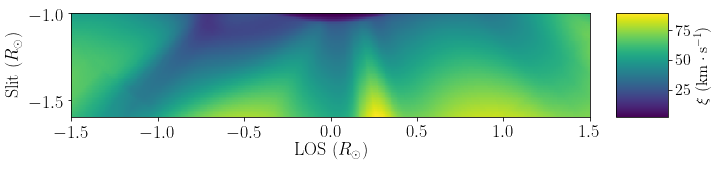

In [10]:
cos_theta = np.sqrt(1 - np.square(bx)/(np.square(bx)+np.square(by)+np.square(bz)))
vnt = 0.5*np.sqrt((I01 + I02)/m_p/n)*cos_theta
fig, ax = plt.subplots(figsize=(12,6))
im = ax.pcolormesh(awsom_x,awsom_z,vnt[:,10,:]/1e5)
ax.axis('scaled')
ax.set_xlabel(r'LOS $(R_\odot)$',fontsize=18)
ax.set_ylabel(r'Slit $(R_\odot)$',fontsize=18)
ax.tick_params(labelsize=18)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
clb_ax = inset_axes(ax,width="10%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.05, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
clb_ax.tick_params(labelsize=16)
clb_ax.yaxis.get_offset_text().set_fontsize(16)
clb_ax.set_ylabel(r'$\xi\ (\mathrm{km\cdot s^{-1}})$',fontsize=16)
plt.subplots_adjust(bottom = 0.12,left=0.2,top=0.97,right=0.8)
plt.savefig(fname = '../figs/v_nt.pdf', dpi = 300, format = 'pdf')
plt.savefig(fname = '../figs/v_nt.png', dpi = 300, format = 'png')

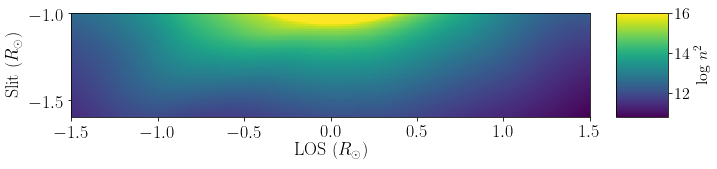

In [11]:
fig, ax = plt.subplots(figsize=(12,6))
im = ax.pcolormesh(awsom_x,awsom_z,np.log10(np.square(n[:,10,:])),vmax=16)
ax.axis('scaled')
ax.set_xlabel(r'LOS $(R_\odot)$',fontsize=18)
ax.set_ylabel(r'Slit $(R_\odot)$',fontsize=18)
ax.tick_params(labelsize=18)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
clb_ax = inset_axes(ax,width="10%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.05, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
clb_ax.tick_params(labelsize=16)
clb_ax.yaxis.get_offset_text().set_fontsize(16)
clb_ax.set_ylabel(r'log $n^2$',fontsize=16)
plt.subplots_adjust(bottom = 0.12,left=0.2,top=0.97,right=0.8)
plt.savefig(fname = '../figs/n_sq.pdf', dpi = 300, format = 'pdf')
plt.savefig(fname = '../figs/n_sq.png', dpi = 300, format = 'png')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


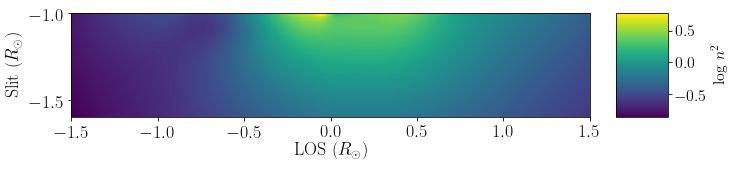

In [19]:
fig, ax = plt.subplots(figsize=(12,6))
im = ax.pcolormesh(awsom_x,awsom_z,np.log10(b_tot[:,10,:]))
ax.axis('scaled')
ax.set_xlabel(r'LOS $(R_\odot)$',fontsize=18)
ax.set_ylabel(r'Slit $(R_\odot)$',fontsize=18)
ax.tick_params(labelsize=18)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
clb_ax = inset_axes(ax,width="10%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.05, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
clb_ax.tick_params(labelsize=16)
clb_ax.yaxis.get_offset_text().set_fontsize(16)
clb_ax.set_ylabel(r'log $n^2$',fontsize=16)
plt.subplots_adjust(bottom = 0.12,left=0.2,top=0.97,right=0.8)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


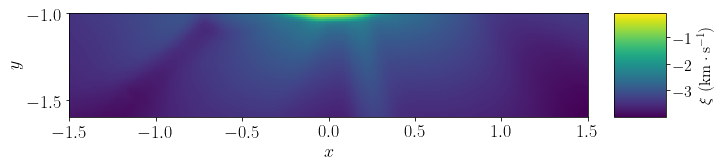

In [13]:
fig, ax = plt.subplots(figsize=(12,6))
im = ax.pcolormesh(awsom_x,awsom_z,np.log10(I01[:,10,:] + I02[:,10,:]))
ax.set_xlabel(r'$x$',fontsize=18)
ax.axis('scaled')
ax.set_ylabel(r'$y$',fontsize=18)
ax.tick_params(labelsize=18)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
clb_ax = inset_axes(ax,width="10%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.05, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
clb_ax.tick_params(labelsize=16)
clb_ax.yaxis.get_offset_text().set_fontsize(16)
clb_ax.set_ylabel(r'$\xi\ (\mathrm{km\cdot s^{-1}})$',fontsize=16)
plt.subplots_adjust(bottom = 0.12,left=0.2,top=0.97,right=0.8)

In [9]:
turbo_colormap_data = np.array(
                       [[0.18995,0.07176,0.23217],
                       [0.19483,0.08339,0.26149],
                       [0.19956,0.09498,0.29024],
                       [0.20415,0.10652,0.31844],
                       [0.20860,0.11802,0.34607],
                       [0.21291,0.12947,0.37314],
                       [0.21708,0.14087,0.39964],
                       [0.22111,0.15223,0.42558],
                       [0.22500,0.16354,0.45096],
                       [0.22875,0.17481,0.47578],
                       [0.23236,0.18603,0.50004],
                       [0.23582,0.19720,0.52373],
                       [0.23915,0.20833,0.54686],
                       [0.24234,0.21941,0.56942],
                       [0.24539,0.23044,0.59142],
                       [0.24830,0.24143,0.61286],
                       [0.25107,0.25237,0.63374],
                       [0.25369,0.26327,0.65406],
                       [0.25618,0.27412,0.67381],
                       [0.25853,0.28492,0.69300],
                       [0.26074,0.29568,0.71162],
                       [0.26280,0.30639,0.72968],
                       [0.26473,0.31706,0.74718],
                       [0.26652,0.32768,0.76412],
                       [0.26816,0.33825,0.78050],
                       [0.26967,0.34878,0.79631],
                       [0.27103,0.35926,0.81156],
                       [0.27226,0.36970,0.82624],
                       [0.27334,0.38008,0.84037],
                       [0.27429,0.39043,0.85393],
                       [0.27509,0.40072,0.86692],
                       [0.27576,0.41097,0.87936],
                       [0.27628,0.42118,0.89123],
                       [0.27667,0.43134,0.90254],
                       [0.27691,0.44145,0.91328],
                       [0.27701,0.45152,0.92347],
                       [0.27698,0.46153,0.93309],
                       [0.27680,0.47151,0.94214],
                       [0.27648,0.48144,0.95064],
                       [0.27603,0.49132,0.95857],
                       [0.27543,0.50115,0.96594],
                       [0.27469,0.51094,0.97275],
                       [0.27381,0.52069,0.97899],
                       [0.27273,0.53040,0.98461],
                       [0.27106,0.54015,0.98930],
                       [0.26878,0.54995,0.99303],
                       [0.26592,0.55979,0.99583],
                       [0.26252,0.56967,0.99773],
                       [0.25862,0.57958,0.99876],
                       [0.25425,0.58950,0.99896],
                       [0.24946,0.59943,0.99835],
                       [0.24427,0.60937,0.99697],
                       [0.23874,0.61931,0.99485],
                       [0.23288,0.62923,0.99202],
                       [0.22676,0.63913,0.98851],
                       [0.22039,0.64901,0.98436],
                       [0.21382,0.65886,0.97959],
                       [0.20708,0.66866,0.97423],
                       [0.20021,0.67842,0.96833],
                       [0.19326,0.68812,0.96190],
                       [0.18625,0.69775,0.95498],
                       [0.17923,0.70732,0.94761],
                       [0.17223,0.71680,0.93981],
                       [0.16529,0.72620,0.93161],
                       [0.15844,0.73551,0.92305],
                       [0.15173,0.74472,0.91416],
                       [0.14519,0.75381,0.90496],
                       [0.13886,0.76279,0.89550],
                       [0.13278,0.77165,0.88580],
                       [0.12698,0.78037,0.87590],
                       [0.12151,0.78896,0.86581],
                       [0.11639,0.79740,0.85559],
                       [0.11167,0.80569,0.84525],
                       [0.10738,0.81381,0.83484],
                       [0.10357,0.82177,0.82437],
                       [0.10026,0.82955,0.81389],
                       [0.09750,0.83714,0.80342],
                       [0.09532,0.84455,0.79299],
                       [0.09377,0.85175,0.78264],
                       [0.09287,0.85875,0.77240],
                       [0.09267,0.86554,0.76230],
                       [0.09320,0.87211,0.75237],
                       [0.09451,0.87844,0.74265],
                       [0.09662,0.88454,0.73316],
                       [0.09958,0.89040,0.72393],
                       [0.10342,0.89600,0.71500],
                       [0.10815,0.90142,0.70599],
                       [0.11374,0.90673,0.69651],
                       [0.12014,0.91193,0.68660],
                       [0.12733,0.91701,0.67627],
                       [0.13526,0.92197,0.66556],
                       [0.14391,0.92680,0.65448],
                       [0.15323,0.93151,0.64308],
                       [0.16319,0.93609,0.63137],
                       [0.17377,0.94053,0.61938],
                       [0.18491,0.94484,0.60713],
                       [0.19659,0.94901,0.59466],
                       [0.20877,0.95304,0.58199],
                       [0.22142,0.95692,0.56914],
                       [0.23449,0.96065,0.55614],
                       [0.24797,0.96423,0.54303],
                       [0.26180,0.96765,0.52981],
                       [0.27597,0.97092,0.51653],
                       [0.29042,0.97403,0.50321],
                       [0.30513,0.97697,0.48987],
                       [0.32006,0.97974,0.47654],
                       [0.33517,0.98234,0.46325],
                       [0.35043,0.98477,0.45002],
                       [0.36581,0.98702,0.43688],
                       [0.38127,0.98909,0.42386],
                       [0.39678,0.99098,0.41098],
                       [0.41229,0.99268,0.39826],
                       [0.42778,0.99419,0.38575],
                       [0.44321,0.99551,0.37345],
                       [0.45854,0.99663,0.36140],
                       [0.47375,0.99755,0.34963],
                       [0.48879,0.99828,0.33816],
                       [0.50362,0.99879,0.32701],
                       [0.51822,0.99910,0.31622],
                       [0.53255,0.99919,0.30581],
                       [0.54658,0.99907,0.29581],
                       [0.56026,0.99873,0.28623],
                       [0.57357,0.99817,0.27712],
                       [0.58646,0.99739,0.26849],
                       [0.59891,0.99638,0.26038],
                       [0.61088,0.99514,0.25280],
                       [0.62233,0.99366,0.24579],
                       [0.63323,0.99195,0.23937],
                       [0.64362,0.98999,0.23356],
                       [0.65394,0.98775,0.22835],
                       [0.66428,0.98524,0.22370],
                       [0.67462,0.98246,0.21960],
                       [0.68494,0.97941,0.21602],
                       [0.69525,0.97610,0.21294],
                       [0.70553,0.97255,0.21032],
                       [0.71577,0.96875,0.20815],
                       [0.72596,0.96470,0.20640],
                       [0.73610,0.96043,0.20504],
                       [0.74617,0.95593,0.20406],
                       [0.75617,0.95121,0.20343],
                       [0.76608,0.94627,0.20311],
                       [0.77591,0.94113,0.20310],
                       [0.78563,0.93579,0.20336],
                       [0.79524,0.93025,0.20386],
                       [0.80473,0.92452,0.20459],
                       [0.81410,0.91861,0.20552],
                       [0.82333,0.91253,0.20663],
                       [0.83241,0.90627,0.20788],
                       [0.84133,0.89986,0.20926],
                       [0.85010,0.89328,0.21074],
                       [0.85868,0.88655,0.21230],
                       [0.86709,0.87968,0.21391],
                       [0.87530,0.87267,0.21555],
                       [0.88331,0.86553,0.21719],
                       [0.89112,0.85826,0.21880],
                       [0.89870,0.85087,0.22038],
                       [0.90605,0.84337,0.22188],
                       [0.91317,0.83576,0.22328],
                       [0.92004,0.82806,0.22456],
                       [0.92666,0.82025,0.22570],
                       [0.93301,0.81236,0.22667],
                       [0.93909,0.80439,0.22744],
                       [0.94489,0.79634,0.22800],
                       [0.95039,0.78823,0.22831],
                       [0.95560,0.78005,0.22836],
                       [0.96049,0.77181,0.22811],
                       [0.96507,0.76352,0.22754],
                       [0.96931,0.75519,0.22663],
                       [0.97323,0.74682,0.22536],
                       [0.97679,0.73842,0.22369],
                       [0.98000,0.73000,0.22161],
                       [0.98289,0.72140,0.21918],
                       [0.98549,0.71250,0.21650],
                       [0.98781,0.70330,0.21358],
                       [0.98986,0.69382,0.21043],
                       [0.99163,0.68408,0.20706],
                       [0.99314,0.67408,0.20348],
                       [0.99438,0.66386,0.19971],
                       [0.99535,0.65341,0.19577],
                       [0.99607,0.64277,0.19165],
                       [0.99654,0.63193,0.18738],
                       [0.99675,0.62093,0.18297],
                       [0.99672,0.60977,0.17842],
                       [0.99644,0.59846,0.17376],
                       [0.99593,0.58703,0.16899],
                       [0.99517,0.57549,0.16412],
                       [0.99419,0.56386,0.15918],
                       [0.99297,0.55214,0.15417],
                       [0.99153,0.54036,0.14910],
                       [0.98987,0.52854,0.14398],
                       [0.98799,0.51667,0.13883],
                       [0.98590,0.50479,0.13367],
                       [0.98360,0.49291,0.12849],
                       [0.98108,0.48104,0.12332],
                       [0.97837,0.46920,0.11817],
                       [0.97545,0.45740,0.11305],
                       [0.97234,0.44565,0.10797],
                       [0.96904,0.43399,0.10294],
                       [0.96555,0.42241,0.09798],
                       [0.96187,0.41093,0.09310],
                       [0.95801,0.39958,0.08831],
                       [0.95398,0.38836,0.08362],
                       [0.94977,0.37729,0.07905],
                       [0.94538,0.36638,0.07461],
                       [0.94084,0.35566,0.07031],
                       [0.93612,0.34513,0.06616],
                       [0.93125,0.33482,0.06218],
                       [0.92623,0.32473,0.05837],
                       [0.92105,0.31489,0.05475],
                       [0.91572,0.30530,0.05134],
                       [0.91024,0.29599,0.04814],
                       [0.90463,0.28696,0.04516],
                       [0.89888,0.27824,0.04243],
                       [0.89298,0.26981,0.03993],
                       [0.88691,0.26152,0.03753],
                       [0.88066,0.25334,0.03521],
                       [0.87422,0.24526,0.03297],
                       [0.86760,0.23730,0.03082],
                       [0.86079,0.22945,0.02875],
                       [0.85380,0.22170,0.02677],
                       [0.84662,0.21407,0.02487],
                       [0.83926,0.20654,0.02305],
                       [0.83172,0.19912,0.02131],
                       [0.82399,0.19182,0.01966],
                       [0.81608,0.18462,0.01809],
                       [0.80799,0.17753,0.01660],
                       [0.79971,0.17055,0.01520],
                       [0.79125,0.16368,0.01387],
                       [0.78260,0.15693,0.01264],
                       [0.77377,0.15028,0.01148],
                       [0.76476,0.14374,0.01041],
                       [0.75556,0.13731,0.00942],
                       [0.74617,0.13098,0.00851],
                       [0.73661,0.12477,0.00769],
                       [0.72686,0.11867,0.00695],
                       [0.71692,0.11268,0.00629],
                       [0.70680,0.10680,0.00571],
                       [0.69650,0.10102,0.00522],
                       [0.68602,0.09536,0.00481],
                       [0.67535,0.08980,0.00449],
                       [0.66449,0.08436,0.00424],
                       [0.65345,0.07902,0.00408],
                       [0.64223,0.07380,0.00401],
                       [0.63082,0.06868,0.00401],
                       [0.61923,0.06367,0.00410],
                       [0.60746,0.05878,0.00427],
                       [0.59550,0.05399,0.00453],
                       [0.58336,0.04931,0.00486],
                       [0.57103,0.04474,0.00529],
                       [0.55852,0.04028,0.00579],
                       [0.54583,0.03593,0.00638],
                       [0.53295,0.03169,0.00705],
                       [0.51989,0.02756,0.00780],
                       [0.50664,0.02354,0.00863],
                       [0.49321,0.01963,0.00955],
                       [0.47960,0.01583,0.01055]])




def RGBToPyCmap(rgbdata):
    nsteps = rgbdata.shape[0]
    stepaxis = np.linspace(0, 1, nsteps)

    rdata=[]; gdata=[]; bdata=[]
    for istep in range(nsteps):
        r = rgbdata[istep,0]
        g = rgbdata[istep,1]
        b = rgbdata[istep,2]
        rdata.append((stepaxis[istep], r, r))
        gdata.append((stepaxis[istep], g, g))
        bdata.append((stepaxis[istep], b, b))

    mpl_data = {'red':   rdata,
                 'green': gdata,
                 'blue':  bdata}

    return mpl_data


mpl_data = RGBToPyCmap(turbo_colormap_data)
plt.register_cmap(name='turbo', data=mpl_data, lut=turbo_colormap_data.shape[0])

mpl_data_r = RGBToPyCmap(turbo_colormap_data[::-1,:])
plt.register_cmap(name='turbo_r', data=mpl_data_r, lut=turbo_colormap_data.shape[0])